In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

spray_df = pd.read_csv("../data/spray.csv")

test_df = pd.read_csv("../data/test.csv")

train_df = pd.read_csv("../data/train.csv")

weather_df = pd.read_csv("../data/weather.csv")

CHECK FOR NAN VALUES

#### MISSING VALUES:

According to the documentation '-' denotes unavailable values and 'M' denotes Missing values so we can replace both of these with Nan for now  

In [2]:
weather_df=weather_df.replace('-', np.nan)
weather_df=weather_df.replace('M', np.nan)

In [3]:
print("TRAIN_DF:")
print(train_df.isnull().sum())
print("TEST_DF:")
print(test_df.isnull().sum())
print("SPRAY_DF:")
print(spray_df.isnull().sum())
print("WEATHER_DF:")
print(weather_df.isnull().sum())

TRAIN_DF:
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64
TEST_DF:
Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64
SPRAY_DF:
Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64
WEATHER_DF:
Station           0
Date              0
Tmax              0
Tmin              0
Tavg             11
Depart         1472
DewPoint          0
WetBulb           4
Heat             11
Cool             11
Sunrise 

Helper functions to fill Nan values in weather data

In [4]:
def fill_Tavg(x1,x2,x3):
    if pd.isnull(x3):
        x3=np.ceil((x1+x2)/2)
        return x3
    else:
        return x3
    
def calc_decadent_normal(x1,x2):
    if pd.isnull(x2):
        return np.nan
    else:
        return int(x1)-int(x2)

In [5]:
""" Simply calculate Tavg by taking the mean of Tmax and Tmin to fill nan values """

weather_df['Tavg']=weather_df.apply(lambda x: fill_Tavg(x['Tmax'], x['Tmin'], x['Tavg']), axis=1)

##### Depart from Normal in Meteorology means: 
"Temperature departure from the normal indicates if the dekadal average temperatures were above or below the 30-year normal. It is calculated for each grid cell by subtracting the average air temperature from the 30-year normal (from 1961-1990). 

Source: https://ipad.fas.usda.gov/cropexplorer/description.aspx?legendid=204#:~:text=Temperature%20departure%20from%20the%20normal,(from%201961%2D1990).


In [6]:
""" So first we calculate the Decadent Normal Temp. for each cell and then use it to 
fill the NaN values in Tavg column. """

weather_df['decadent_normal']=weather_df.apply(lambda x: calc_decadent_normal(x['Tavg'], x['Depart']), axis=1)
weather_df['decadent_normal']=weather_df['decadent_normal'].fillna(method='ffill')
weather_df['Depart']=weather_df.apply(lambda x: int(x['Tavg'])-int(x['decadent_normal']), axis=1)

weather_df=weather_df.drop(['decadent_normal'], axis=1)

In [7]:
weather_df['WetBulb'] = weather_df['WetBulb'].fillna(method='ffill')

In [8]:
""" There is no clear documentation of what Heat and Cool represents in the dataset but, we can
clearly see a pattern where the values of station1 and station2 on the same date are fairly similar
Therefore, we can simply use the values from station1 for station 2 by ffill
"""

weather_df['Heat'] = weather_df['Heat'].fillna(method='ffill')
weather_df['Cool'] = weather_df['Cool'].fillna(method='ffill')

#### According to the data in the problem statement:

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
<br>Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

Both these stations are very close by so they should experience same times for 
both Sunrise and Sunset so we can simply use forward fill from pandas to use the last 
value from that column.

In [9]:
weather_df['Sunrise'] = weather_df['Sunrise'].fillna(method='ffill')
weather_df['Sunset'] = weather_df['Sunset'].fillna(method='ffill')

In [10]:
weather_df=weather_df.drop(['CodeSum'], axis=1)

#### Since all columns of Water1 had missing data and Depth, Snowfall columns had constant values we can drop this column

In [11]:
weather_df=weather_df.drop(['Water1'], axis=1)

weather_df=weather_df.drop(['Depth', 'SnowFall'], axis=1)

#### In meteorology, a trace denotes an amount of precipitation, such as rain or snow, that is greater than zero, but is too small to be measured by standard units or methods of measurement. The designation of a trace rather than zero is used to indicate that precipitation did fall, but not enough to be measured reliably. 

Source: https://www.thoughtco.com/what-is-trace-of-precipitation-3444238#:~:text=If%20you%20must%20convert%20a%20trace%20to%20a%20numerical%20amount%2C%20it%20would%20equal%200.00.


In [12]:
weather_df['PrecipBool'] = weather_df['PrecipTotal'].apply(lambda x: 'N' if x=='0.00' else 'Y')

weather_df['PrecipTotal'] = weather_df['PrecipTotal'].apply(lambda x: 0.00 if str(x).strip()=='T' or pd.isnull(x) else x)

weather_df.insert(13, 'PrecipBool', weather_df.pop('PrecipBool'))

In [13]:
""" Very less variation in data and small number of nan values so we can use forward fill """

weather_df['StnPressure'] = weather_df['StnPressure'].fillna(method='ffill') 
weather_df['SeaLevel'] = weather_df['SeaLevel'].fillna(method='ffill')

In [14]:
""" Since only 3 values are missing from a large data we can simply fill them using median of that column"""

median_speed = weather_df['AvgSpeed'].median()
weather_df['AvgSpeed'] = weather_df['AvgSpeed'].fillna(value=median_speed)

In [15]:
station_1=weather_df[weather_df.Station == 1]
station_2=weather_df[weather_df.Station == 2]

print(station_1.isnull().sum())
print(station_2.isnull().sum())

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
PrecipTotal    0
PrecipBool     0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64
Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
PrecipTotal    0
PrecipBool     0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64


In [16]:
station_1.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,PrecipBool,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,0.00,N,29.10,29.82,1.7,27,9.2
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,0.00,N,29.38,30.09,13.0,4,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,0.00,N,29.39,30.12,11.7,7,11.9
6,1,2007-05-04,66,49,58,4,41,50,7,0,0444,1852,0.0,Y,29.31,30.05,10.4,8,10.8
8,1,2007-05-05,66,53,60,5,38,49,5,0,0443,1853,0.0,Y,29.40,30.10,11.7,7,12.0


In [17]:
station_2.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,PrecipBool,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2,2007-05-01,84,52,68,15,51,57,0,3,0448,1849,0.00,N,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60,43,52,-2,42,47,13,0,0447,1850,0.00,N,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67,48,58,4,40,50,7,0,0446,1851,0.00,N,29.46,30.12,12.9,6,13.2
7,2,2007-05-04,78,51,65.0,11,42,50,7,0,0444,1852,0.00,N,29.36,30.04,10.1,7,10.4
9,2,2007-05-05,66,54,60,5,39,50,5,0,0443,1853,0.0,Y,29.46,30.09,11.2,7,11.5


In [18]:
weather_df=weather_df.drop(['Sunrise', 'Sunset'], axis=1)

### MERGE WEATHER DATA WITH TRAINING DATA ON THE DATE COLUMN

In [19]:
train_df = train_df.merge(weather_df, on='Date')
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,WetBulb,Heat,Cool,PrecipTotal,PrecipBool,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,65,0,9,0.00,N,29.39,30.11,5.8,18,6.5
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,66,0,12,0.00,N,29.44,30.09,5.8,16,7.4
2,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,65,0,9,0.00,N,29.39,30.11,5.8,18,6.5
3,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,66,0,12,0.00,N,29.44,30.09,5.8,16,7.4
4,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,65,0,9,0.00,N,29.39,30.11,5.8,18,6.5


### FEATURE SELECTION

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21012 entries, 0 to 21011
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    21012 non-null  object 
 1   Address                 21012 non-null  object 
 2   Species                 21012 non-null  object 
 3   Block                   21012 non-null  int64  
 4   Street                  21012 non-null  object 
 5   Trap                    21012 non-null  object 
 6   AddressNumberAndStreet  21012 non-null  object 
 7   Latitude                21012 non-null  float64
 8   Longitude               21012 non-null  float64
 9   AddressAccuracy         21012 non-null  int64  
 10  NumMosquitos            21012 non-null  int64  
 11  WnvPresent              21012 non-null  int64  
 12  Station                 21012 non-null  int64  
 13  Tmax                    21012 non-null  int64  
 14  Tmin                    21012 non-null

In [21]:
weather_df['Tavg'] = weather_df['Tavg'].astype(int)
weather_df['WetBulb'] = weather_df['WetBulb'].astype(int)
weather_df['Heat'] = weather_df['Heat'].astype(int)
weather_df['Cool'] = weather_df['Cool'].astype(int)
weather_df['PrecipTotal'] = weather_df['PrecipTotal'].astype(float)
weather_df['StnPressure'] = weather_df['StnPressure'].astype(float)
weather_df['SeaLevel'] = weather_df['SeaLevel'].astype(float)
weather_df['AvgSpeed'] = weather_df['AvgSpeed'].astype(float)

In [22]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
train_df['Species']= label_encoder.fit_transform(train_df['Species']) 
train_df['PrecipBool']= label_encoder.fit_transform(train_df['PrecipBool'])

train_df['WnvPresent'] = train_df['WnvPresent'].astype(object)
train_df['PrecipBool'] = train_df['PrecipBool'].astype(object)

#### Since most of our features are numerical we can use Pearson Correlation to find identical features as they are unnecessary and remove them to make our model robust

<AxesSubplot:>

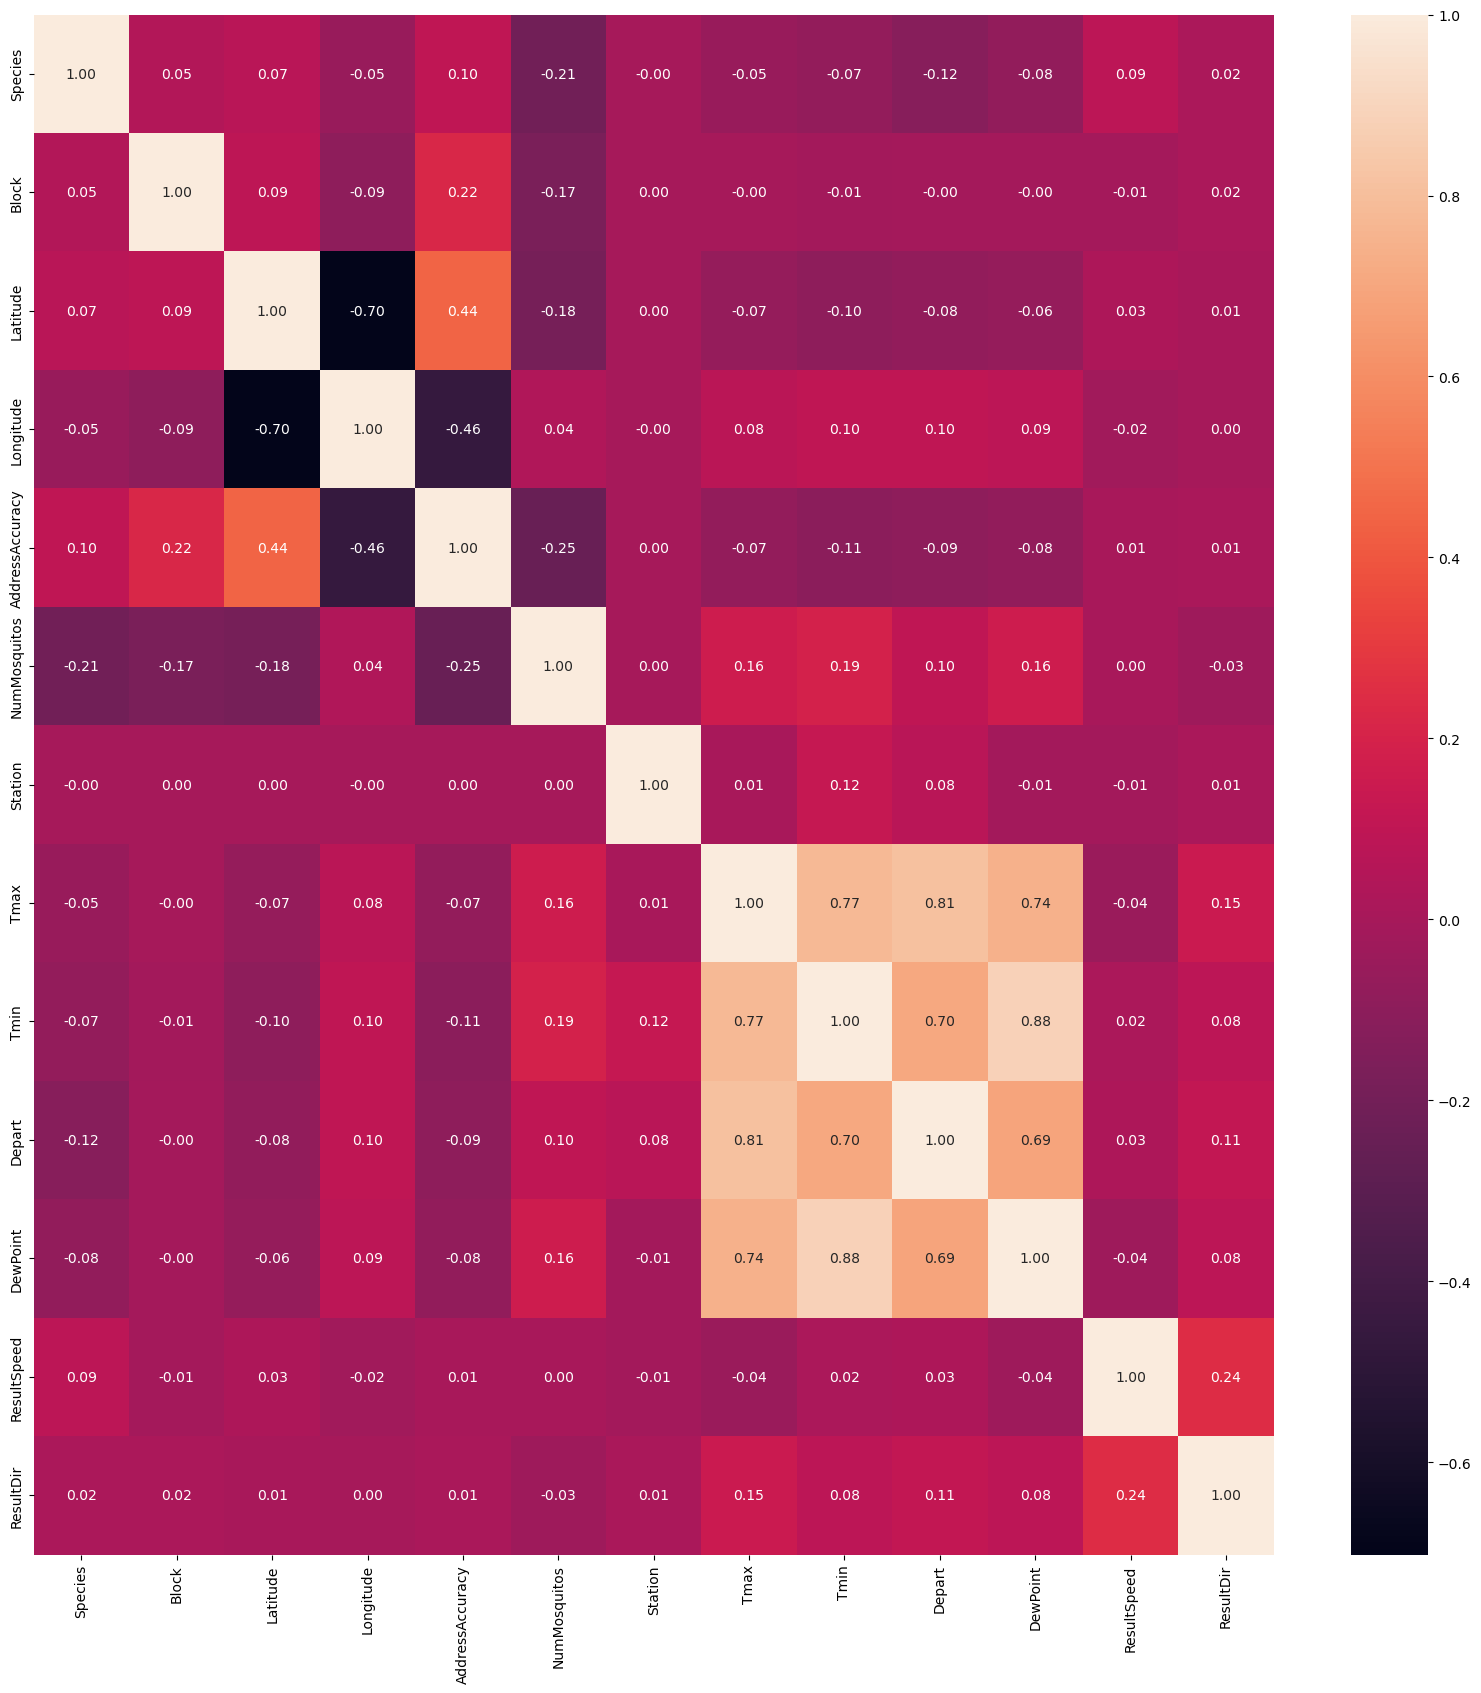

In [23]:
corr_matrix = train_df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linecolor='black')

In [28]:
def coll_checker(df, tol): #remember to remove target!
    cor_matrix = df.corr().abs()
    upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
    return [column for column in upper_tri.columns if any(upper_tri[column] > tol)]

In [29]:
to_drop = coll_checker(train_df,0.8)

In [30]:
train_df=train_df.drop(to_drop, axis=1)

train_df.to_csv('clean_train.csv')

<AxesSubplot:>

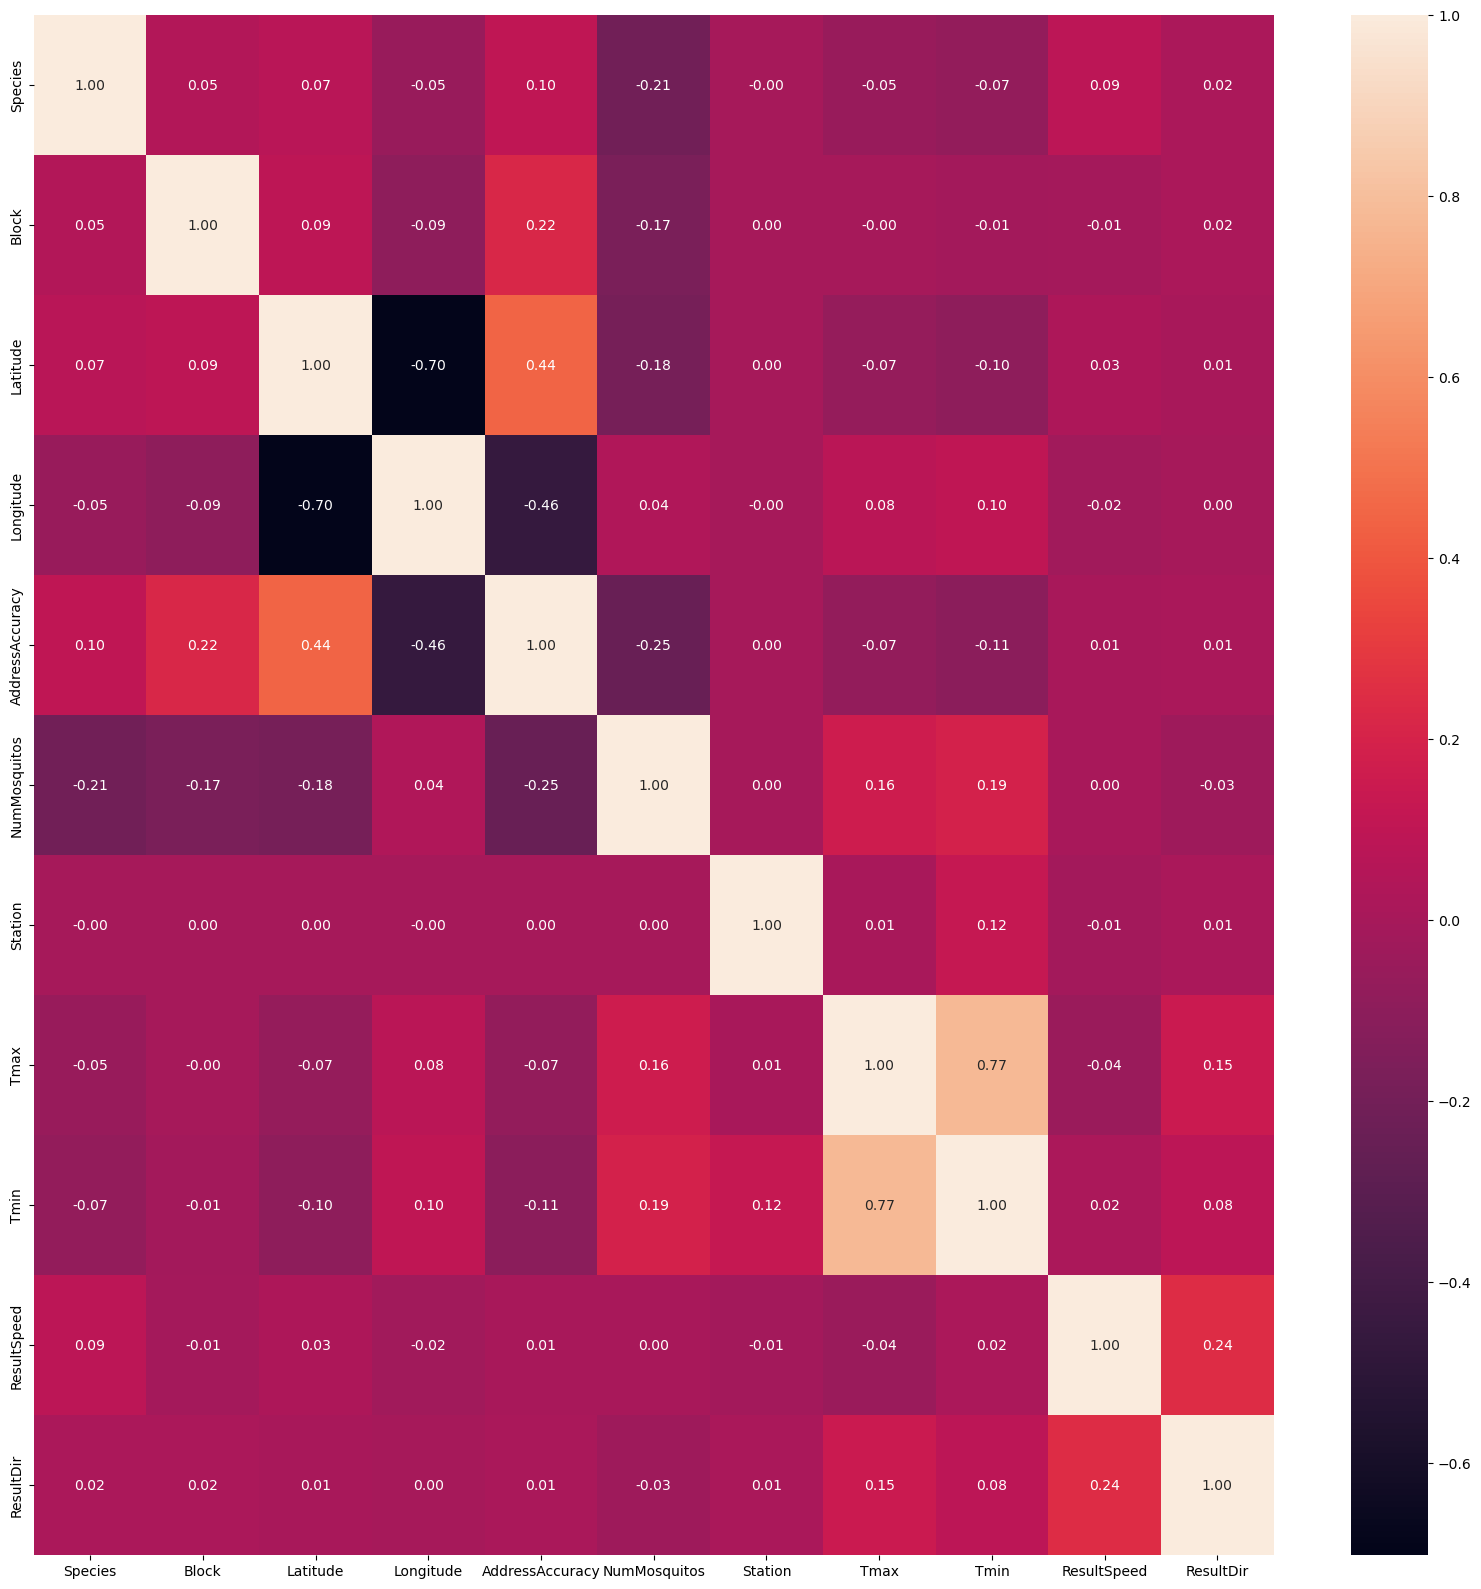

In [31]:
corr_matrix = train_df.corr()

plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linecolor='black')